In [1]:
pip install "pydicom"


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install "numpy"

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install "scipy"

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install "skimage"

  Using cached skimage-0.0.tar.gz (757 bytes)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      
      *** Please install the `scikit-image` package (instead of `skimage`) ***
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install "scikit-image"

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install "matplotlib"

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install "plotly"

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install ipywidgets==7.6.0

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install plotly==5.19.0

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pydicom
import numpy as np
import scipy
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
import matplotlib
import ipywidgets
import os
import copy
from math import *
import matplotlib.pyplot as plt
from functools import reduce

In [11]:
from scipy.linalg import norm
import scipy.ndimage

In [12]:
from ipywidgets.widgets import * 
import ipywidgets as widgets

In [13]:
pip install "chart_studio"

Note: you may need to restart the kernel to use updated packages.


In [14]:
# plotly 3D interactive graphs 
import plotly
from plotly.graph_objs import *
import chart_studio.plotly as py

In [15]:
# set plotly credentials here 
# this allows you to send results to your account plotly.tools.set_credentials_file(username=your_username, api_key=your_key)

In [29]:
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in               
              os.listdir(path)]
    slices = [s for s in slices if 'SliceLocation' in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[0].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[0].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    

    return np.array(image, dtype=np.int16)

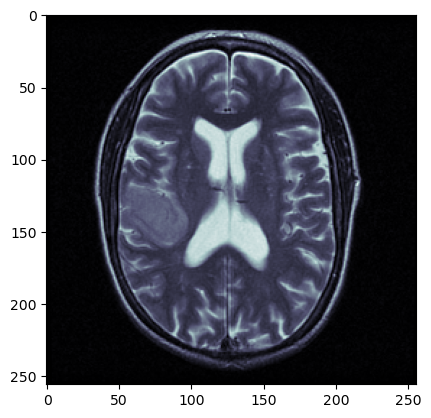

In [33]:
# set path and load files 
path = (os.path.expanduser("~/Desktop/DICOM"))
patient_dicom = load_scan(path)
patient_pixels = get_pixels_hu(patient_dicom)
#sanity check
plt.imshow(patient_pixels[0], cmap=plt.cm.bone)

In [60]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

In [73]:
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= 0, dtype=np.int8)+1
    labels = measure.label(binary_image)
 
    # Pick the pixel in the very corner to determine which label is air.
    # Improvement: Pick multiple background labels from around the patient
    # More resistant to “trays” on which the patient lays cutting the air around the person in half
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
 
    # Remove other air pockets inside body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

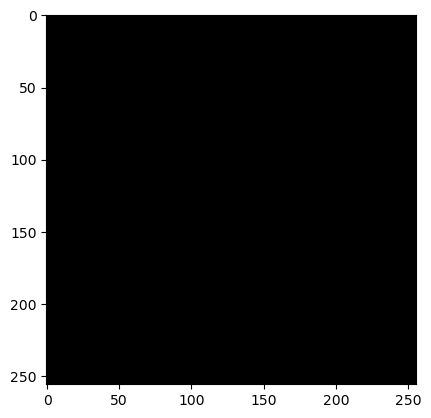

In [74]:
# get masks 
segmented_lungs = segment_lung_mask(patient_pixels,    
                  fill_lung_structures=False)
segmented_lungs_fill = segment_lung_mask(patient_pixels,     
                       fill_lung_structures=True)
internal_structures = segmented_lungs_fill - segmented_lungs
# isolate lung from chest
copied_pixels = copy.deepcopy(patient_pixels)
for i, mask in enumerate(segmented_lungs_fill): 
    get_high_vals = mask == 0
    copied_pixels[i][get_high_vals] = 0
seg_lung_pixels = copied_pixels
# sanity check
plt.imshow(seg_lung_pixels[1], cmap=plt.cm.bone)

In [47]:
class GK:
    def __init__(self, n_clusters=4, max_iter=100, m=2, error=1e-6):
        super().__init__()
        self.u, self.centers, self.f = None, None, None
        self.clusters_count = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
def fit(self, z):
        N = z.shape[0]
        C = self.clusters_count
        centers = []
        u = np.random.dirichlet(np.ones(N), size=C)
        iteration = 0
        while iteration < self.max_iter:
            u2 = u.copy()
            centers = self.next_centers(z, u)
            f = self._covariance(z, centers, u)
            dist = self._distance(z, centers, f)
            u = self.next_u(dist)
            iteration += 1
            # Stopping rule
            if norm(u - u2) < self.error:
                break
        self.f = f
        self.u = u
        self.centers = centers
        return centers
def gk_segment(img, clusters=5, smooth=False):
    # expand dims of binary image (1 channel in z axis)
    new_img = np.expand_dims(img, axis=2)
    # reshape
    x, y, z = new_img.shape
    new_img = new_img.reshape(x * y, z)
    # segment using GK clustering
    algorithm = GK(n_clusters=clusters)
    cluster_centers = algorithm.fit(new_img)
    output = algorithm.predict(new_img)
    segments = cluster_centers[output].astype(np.int32).reshape(x,    
    y)
    # get cluster that takes up least space (nodules / airway)
    min_label = min_label_volume(segments)
    segments[np.where(segments != min_label)] = 0
    segments[np.where(segments == min_label)] = 1
    return segments

In [53]:
# cluster slices (#324 - #328)
dist = 2
selected_slices = seg_brain_pixels[326-dist:326+(dist+1)]
gk_clustered_imgs = np.array([gk_segment(x) for x in    
                              selected_slices])
# display middle slice (slice #326)
plt.imshow(gk_clustered_imgs[5], cmap=plt.cm.bone)

IndexError: index 5 is out of bounds for axis 0 with size 0

NameError: name 'gk_segment_lung' is not defined

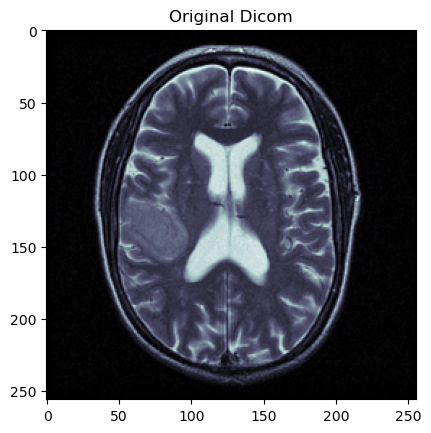

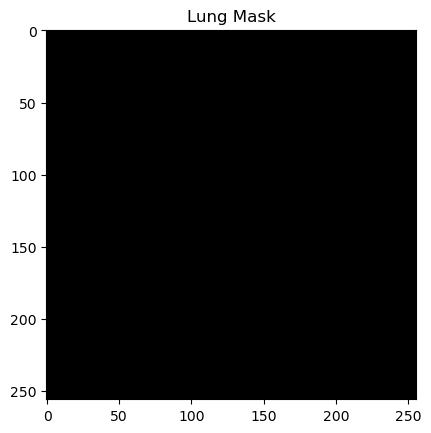

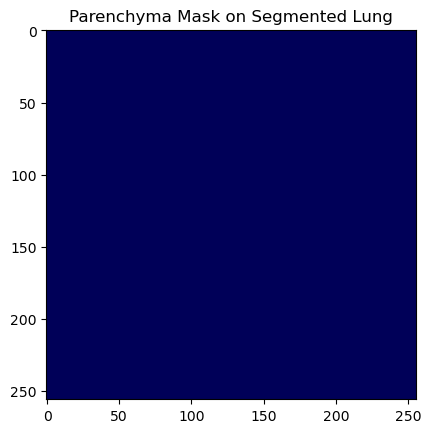

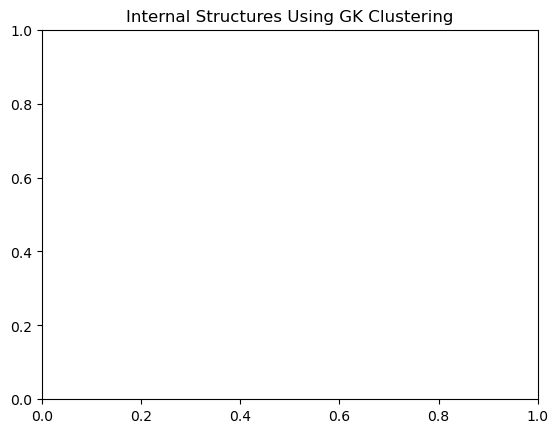

In [55]:
# pick random slice 
slice_id = 0
plt.figure(1)
plt.title('Original Dicom')
plt.imshow(patient_pixels[slice_id], cmap=plt.cm.bone)
plt.figure(2)
plt.title('Lung Mask')
plt.imshow(segmented_lungs_fill[slice_id], cmap=plt.cm.bone)
plt.figure(3)
plt.title('Parenchyma Mask on Segmented Lung')
plt.imshow(seg_lung_pixels[slice_id], cmap=plt.cm.bone)
plt.imshow(internal_structures[slice_id], cmap='jet', alpha=0.7)
plt.figure(4)
plt.title('Internal Structures Using GK Clustering')
plt.imshow(gk_segment_lung[2], cmap=plt.cm.bone)

In [56]:
# slide through dicom images using a slide bar 
plt.figure(1)
def dicom_animation(x):
    plt.imshow(original_dcm_pix[x])
    return x
interact(dicom_animation, x=(0, len(original_dcm_pix)-1))

NameError: name 'original_dcm_pix' is not defined

<Figure size 640x480 with 0 Axes>

In [57]:
def plot_3d(image):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the   
    # camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes_lewiner(p)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of    
    # triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()
# run visualization 
plot_3d(internal_structures_mask)

NameError: name 'internal_structures_mask' is not defined

In [58]:
def interactive_3d_plot(segmented_3d, single_color=False):
    
    verts, faces = make_mesh(segmented_3d, fairing=fairing,   
                             regularization=regularization)
    data1 = plotly_trisurf(verts, faces, single_color, 
                           colormap=plt.cm.RdBu, plot_edges=True)
    axis = dict(
    showbackground=True, 
    backgroundcolor="rgb(230, 230,230)",
    gridcolor="rgb(255, 255, 255)",      
    zerolinecolor="rgb(255, 255, 255)",  
    )
    layout = Layout(
             title='3D Interactive',
             width=800,
             height=800,
             scene=Scene(  
             xaxis=XAxis(axis),
             yaxis=YAxis(axis), 
             zaxis=ZAxis(axis), 
            aspectratio=dict(
                x=1,
                y=1,
                z=1
            ),
            )
            )
    
    fig1 = Figure(data=data1, layout=layout)
    return fig1, verts, faces
# create vertices and faces
def make_mesh(image, step_size=1):
    
    # transpose images
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    # use marching cubes to get verts and faces
    verts, faces, _, _ = measure.marching_cubes_lewiner(p, 
                         step_size=step_size,  
                         allow_degenerate=False)
    return verts, faces
def map_z2color(zval, colormap, vmin, vmax, single_color):
    # green value: 'rgb(0.078, 0.239, 0.133)'
    
    # map the normalized value zval to a corresponding color in the    
    # colormap
    if vmin>vmax:
        raise ValueError('incorrect relation between vmin and vmax')
    if single_color: 
        return 'rgb(0.078, 0.239, 0.133)'
    else:
        # normalized values 
        t = (zval - vmin) / float(vmax - vmin)
        R, G, B, alpha = colormap(t)
        
        return    'rgb('+'{:d}'.format(int(R*255+0.5))+','+'{:d}'.format(int(G*255+0.5))+\
               ','+'{:d}'.format(int(B*255+0.5))+')'
def tri_indices(simplices):
    #simplices is a numpy array defining the simplices of the     
    #triangularization
    #returns the lists of indices i, j, k
    return ([triplet[c] for triplet in simplices] for c in range(3))
def plotly_trisurf(verts, simplices, single_color,   
              colormap='rgb(0.078, 0.239, 0.133)', plot_edges=None):
    #x, y, z are lists of coordinates of the triangle vertices 
    #simplices are the simplices that define the triangularization;
    #simplices  is a numpy array of shape (no_triangles, 3)
    #insert here the  type check for input data
    
    x,y,z = zip(*verts) 
    points3D=np.vstack((x,y,z)).T
    
    # vertices of the surface triangles 
    tri_vertices=map(lambda index: points3D[index], simplices)
    tri_vertices = list(tri_vertices)
    
    # mean values of z-coordinates of triangle vertices
    zmean=[np.mean(tri[:,2]) for tri in tri_vertices]                                            
    min_zmean=np.min(zmean)
    max_zmean=np.max(zmean)  
    facecolor=[map_z2color(zz,  colormap, min_zmean, max_zmean, 
               single_color) for zz in zmean] 
    I,J,K = tri_indices(simplices)
    
    triangles=Mesh3d(x=x,
                     y=y,
                     z=z,
                     facecolor=facecolor, 
                     i=I,
                     j=J,
                     k=K,
                     name=''
                    )
    # the triangle sides are not plotted 
    if plot_edges is None:
        return plotly.graph_objs.Scatter([triangles])
    else:
        #define the lists Xe, Ye, Ze, of x, y, resp z coordinates of   
        #edge end points for each triangle
        #None separates data corresponding to two consecutive    
        #triangles
        lists_coord=[[[T[k%3][c] for k in range(4)]+[ None] for T in 
                       tri_vertices] for c in range(3)]
        Xe, Ye, Ze=[reduce(lambda x,y: x+y, lists_coord[k]) for k in 
                    range(3)]
        
        #define the lines to be plotted
        lines=Scatter3d(x=Xe,
                        y=Ye,
                        z=Ze,
                        mode='lines',
                        line=Line(color= 'rgb(50,50,50)', width=1.5)
               )
        return Data([triangles, lines])
# crop image based on centroid and radius
def crop_image(img, centroid, r=10): 
    img = np.array(img)
    row, column, _ = centroid
    r_min, r_max = int(row - r), int(row + r)
    c_min, c_max = int(column - r), int(column + r)
    cropped = img[r_min:r_max, c_min:c_max]
    return cropped

In [59]:
# crop that specific region in each slice 
centroid = (210, 160, 0)
cropped_region = np.array([crop_image(i, centroid) for i in 
                           gk_clustered_imgs])
# plot it interactively! 
fig, verts, faces = interactive_3d_plot(cropped_region)
py.iplot(fig, filename='region_3d_example')

NameError: name 'fairing' is not defined